# Exercise 5 - SAC
In this last exercise we will train our own agent using [Soft Actor Critic](https://arxiv.org/pdf/1801.01290.pdf). Currently it is one of the state-of-the-art methods for continuous control with similarities to DDPG and TD3 from the last exercise. Once again we will solve the LunarLander environment from Gymnasium to safely land our vehicle on the surface on the moon.

Note: A good introduction to SAC can be found at the [Spinning Up project](https://spinningup.openai.com/en/latest/algorithms/sac.html).

<img src="resources/lunar_lander.gif" alt="Gymnasium" width="20%"/>

<!--  -->
_Agent using random actions to land the lunarlander_

## 0 Setup
These are the same packages as in the last exercise:

In [19]:
!pip install torch
!pip install gymnasium
!pip install "gymnasium[box2d]"
!pip install matplotlib
!pip install imageio

In [20]:
# Imports
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 SAC
Soft-Actor Critic (SAC) is an off-policy actor-critic RL method, which maximizes an objective with **entropy regularization**: $J = J_θ + α H(π_θ)$, where $J_θ$ is the expected return with respect to the parameters $\theta$ of our policy, which we typically maximize, $H$ is the entropy and $\alpha$ is a hyperparameter to balance it. 

---
<span style="color:orange">**EXERCISE**</span>: **SAC Warm-up**
1. What does the the Shannon entropy $H(X)$ of a random variable $X$ describe? (0.5 points) How can we calculate it? (0.5 points)
2. Let $\pi(a|s)$ be a stochastic policy that is already partially trained to some task. What happens if we minimize or maximize its entropy, respectively? (1 point)
3. What is a normal distribution? Is it bounded? (1 point)
4. Describe the difference between $\epsilon$-greedy and softmax exploration. When should we model our policy with a Gaussian instead of a softmax? (1.5 points)
5. What are the consequences of overfitting our policy to specific actions, especially if we want to use it for exploration in our environment? (1 point)
6. Looking at TD3 algorithm from the last excercise, explain how using two Q-networks benifit the training process? (1 point)

**Your answers:**
1. Shannon entropy H(X) of random variable X describes the average amount of information or uncertainty associated with the random variable X. It can be calculated as: <br>
$$
H(X) = - \sum_{i} p(x_i) \log p(x_i)
$$
2. If we minimize its entropy then the actions will be determined more by the policy $\pi(a|s)$ (exploitation). If we increase the entropy there will be more randomness in actions (Exploration).
3. Normal distribution is a bell-shaped, symmetric, contionous probability distribution (defined by mean and standard deviation). It is not bounded and its domain is the whole real-number line.
4. $\epsilon$-greedy selects a random action with probability $\epsilon$ and greedy action with probability 1-$\epsilon$-greedy. While, Softmax exploration assigns the probability to each possible action on the basis of their estimated values by applying a softmax function.<br>
We model with a Gaussian when there is continous action space and we can benefit from the policy output as a mean or standard deviation for each action.
5. Overfitting our policy to specific actions means a compromise on the exploration which result in an agent going for exploiting specific actions and hence leading to poor generalization. The agent will also struggle to perform well in new or unseen states.
6. When we use single Q-network there is a chance that it assigns higher values to certian state-action pairs which can lead to overestimation bias. When we use two Q-networks we want to mitigate the overestimation bias during value estimation which leads to more stability, and accurate values estimation during training. 

## 1.1 Critic
We reuse the Critic implementation from last exercise.

In [21]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        Initialize the Critic network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()


    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], dim=-1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        out = self.fc3(x)
        return out


## 1.2 Actor 
The actor is also explicitly represented by a neural network. In contrast to DDPG, SAC uses a stochastic policy. This means that the actor outputs a probability distribution over the actions. The distribution is parameterized by a mean $\mu$ and a standard deviation $\sigma$. Typically, the stochastic policy is modeled with a squashed diagonal Gaussian distribution. The squashing function is used to ensure that the actions are within the bounds of the environment's action space.

### Reparameterization Trick
The reason for using a stochastic policy is to allow exploration. However, the stochasticity (sampling directly from $\mathcal{N}(\mu(s), \sigma(s))$) makes it difficult to compute the gradients of the loss function. This is where the reparameterization trick comes in. The trick is to sample the action from a deterministic distribution ($\mu(s)$ and $\sigma(s)$) and then add noise ($\mathcal{N}(0, \mathcal{I})$). This way, the gradients can be computed with respect to the deterministic distribution, while the actions are still sampled from the stochastic distribution.

$$
a \sim \mathcal{N}(\mu(s), \sigma(s)) => \mu(s) + \sigma(s) \cdot \mathcal{N}(0, \mathcal{I})
$$

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the Actor**

In this exercise we use state based (not image based) observations. 
The actor should take in an observation and output an action.

**NOTE**: The output of `fc_std` should pass through a `softplus` activation so that the standard deviation is non-negative. Finally, the sampled actions should pass through a `tanh` activation and be scaled and translated according to the action space of the environment. The tanh activation restricts the actions to the [-1,1] range, and the scaling and translation ensures that the action is within the boundaries of the environment's action space.

- fc1: input:(obs_dim), output: 256
- fc_mu: input: 256, output: action_dim
- fc_std: input: 256, output: action_dim

The reparameterization trick in Pytorch can be implemented using the [rsample](https://pytorch.org/docs/stable/distributions.html#torch.distributions.distribution.Distribution.rsample) method of the $\mathcal{N}(\mu(s), \sigma(s))$ distribution object.

The log probability of the action can be calculated using the [log_prob](https://pytorch.org/docs/stable/distributions.html#torch.distributions.distribution.Distribution.log_prob) method of the $\mathcal{N}(\mu(s), \sigma(s))$ distribution object.

action_high and action_low can be determined by examining the env using ``env.action_space.high`` and ``env.action_space.low``.

Implement this architecture.

In [37]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        Initialize the Actor network.

        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        # We are registering scale and bias as buffers so they can be saved and loaded as part of the model.
        # Buffers won't be passed to the optimizer for training!
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )

        # TODO: your code
        self.fc1 = nn.Linear(in_features=obs_dim, out_features=256)
        self.fc_mu = nn.Linear(in_features=256, out_features=action_dim)
        self.fc_std = nn.Linear(in_features=256, out_features=action_dim)

        self.softplus = nn.Softplus()
        self.relu = nn.ReLU()

    def forward(self, obs: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass of the actor network.

        return: mean_action, log_prob_action
        """
        # TODO: your code
        x = self.relu(self.fc1(obs))
        mu = self.fc_mu(x)
        std = self.softplus(self.fc_std(x))
        dist = torch.distributions.Normal(mu, std)

        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(dim=-1, keepdim=True)

        # Enforcing action bounds
        adjusted_action = torch.tanh(action) * self.action_scale + self.action_bias
        adjusted_log_prob = log_prob - torch.log(self.action_scale * (1-torch.tanh(action).pow(2)) + 1e-6)
        return adjusted_action, adjusted_log_prob



## Replay Buffer

We reuse the implementation of our replay buffer from last exercise.


In [23]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

## 1.3 Algorithm
In this section, we will first look at the update formulas of SAC and then implement the entire algorithm.

---
<span style="color:orange">**EXERCISE**</span>: **Updating the critics**

Implement the function ``update_critics`` which gets the sampled data from the replay buffer, calculates the loss of both critics, respectively, and performs an update step.

Note: As our objective has changed, our Q-function also changes as well to include the entropy bonus. The target for our critics is given by (from Spinning Up):

$y = r + \gamma(1-tm)(\min_{j=1,2}Q_{\text{targ, j}}(s', \tilde{a}') - \alpha \log \pi_\theta(\tilde{a}'|s'))$
with action $\tilde{a}' \sim \pi_\theta(\cdot | s')$ sampled from our actor

Be aware, we are using two target networks and take the minimum over both!

In [47]:
def update_critics(
        q1: nn.Module,
        q1_target: nn.Module,
        q1_optimizer: optim.Optimizer,
        q2: nn.Module,
        q2_target: nn.Module,
        q2_optimizer: optim.Optimizer,
        actor_target: nn.Module,
        log_ent_coef: torch.Tensor,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update both of SAC's critics for one optimizer step.

    :param q1: The first critic network.
    :param q1_target: The target first critic network.
    :param q1_optimizer: The first critic's optimizer.
    :param q2: The second critic network.
    :param q2_target: The target second critic network.
    :param q2_optimizer: The second critic's optimizer.
    :param actor: The actor network.
    :param actor_target: The target actor network.
    :param actor_optimizer: The actor's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: 1. Calculate the target
    with torch.no_grad():
       action, action_log_prob = actor_target(next_obs)
       entropy = - log_ent_coef.exp() * action_log_prob
       q1_next = q1_target(next_obs, action)
       q2_next = q2_target(next_obs, action)
       min_q = torch.min(q1_next, q2_next)

       rew = rew.view(-1, 1)
       tm = tm.view(-1, 1)
       y = rew + gamma * (1 - tm) * (min_q + entropy)

    # TODO: 2. Update both q function using our target
    for q, optimizer in [(q1, q1_optimizer), (q2, q2_optimizer)]:
        predicted_q = q(obs, act)
        mse_loss = nn.MSELoss()
        loss = mse_loss(predicted_q, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def update_actor(
    q1: nn.Module,
    q2: nn.Module,
    actor: nn.Module,
    actor_optimizer: optim.Optimizer,
    obs: torch.Tensor,
    log_ent_coef: torch.Tensor,
    ):
    """
    Update the SAC's Actor network for one optimizer step.

    :param critic: The critic network.
    :param actor: The actor network.
    :param actor_optimizer: The actor's optimizer.
    :param obs: Batch of current observations.

    """
    # Actor Update
    action, action_log_prob = actor(obs)
    entropy = - log_ent_coef.exp() * action_log_prob
    q1, q2 = q1(obs, action), q2(obs, action)
    q1_q2 = torch.cat([q1, q2], dim=1)
    min_q = torch.min(q1_q2, 1, keepdim=True)[0]
    actor_loss = (- min_q - entropy).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

def update_entropy_coefficient(
        actor: nn.Module,
        log_ent_coef: torch.Tensor,
        target_entropy: float,
        ent_coef_optimizer: optim.Optimizer,
        obs: torch.Tensor,
    ):
    """
    Automatic update for entropy coefficient (alpha)

    :param actor: the actor network.
    :param log_ent_coef: tensor representing the log of entropy coefficient (log_alpha).
    :param target_entropy: tensor representing the desired target entropy.
    :param ent_coef_optimizer: torch optimizer for entropy coefficient.
    :param obs: current batch observation.
    """
    _, action_log_prob = actor(obs)
    ent_coef_loss = -(log_ent_coef.exp() * (action_log_prob + target_entropy).detach()).mean()
    ent_coef_optimizer.zero_grad()
    ent_coef_loss.backward()
    ent_coef_optimizer.step()


## 1.4 Polyak Update of the target networks
It is common to update the target networks very slowly at every step. We use the polyak update from last exercise again.

In [48]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    with torch.no_grad():
        for param, target_param in zip(params, target_params):
            target_param.data.mul_(1 - tau)
            torch.add(target_param.data, param.data, alpha=tau, out=target_param.data)

We are now putting it all together. This implementation is very similar to the DDPG one. 

---
<span style="color:orange">**EXERCISE**</span>: **Implementing the SAC Agent**

Implement the SAC agent by filling in the missing gaps in the code.

In [49]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class SACAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
            target_entropy=-1.0,
        ):
        """
        Initialize the SAC agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau
        self.target_entropy=target_entropy

        # Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize two critic and one actor network
        self.q1 = Critic(env.observation_space.shape[0], env.action_space.shape[0])
        self.q2 = Critic(env.observation_space.shape[0], env.action_space.shape[0])
        self.actor = Actor(env.observation_space.shape[0], env.action_space.shape[0], env.action_space.low, env.action_space.high)
        self.log_ent_coef = torch.zeros(1, requires_grad=True)

        # TODO: Initialze two target critic and one target actor networks and load the corresponding state_dicts
        self.q1_target = Critic(env.observation_space.shape[0], env.action_space.shape[0])
        self.q2_target = Critic(env.observation_space.shape[0], env.action_space.shape[0])
        self.actor_target = Actor(env.observation_space.shape[0], env.action_space.shape[0], env.action_space.low, env.action_space.high)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        self.actor_target.load_state_dict(self.actor.state_dict())

        # TODO: Create ADAM optimizer for the Critic and Actor networks
        self.q1_optimizer = optim.Adam(self.q1.parameters(),lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(),lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(),lr=lr)
        self.ent_coef_optimizer = optim.Adam([self.log_ent_coef], lr=lr)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the SAC agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # Choose action and execute
                with torch.no_grad():
                    action, _ = self.actor(torch.as_tensor(obs).float())
                    action = action.cpu().numpy().clip(self.env.action_space.low, self.env.action_space.high)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated),
                )

                # Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Critic network
                update_critics(
                    self.q1,
                    self.q1_target,
                    self.q1_optimizer,
                    self.q2,
                    self.q2_target,
                    self.q2_optimizer,
                    self.actor_target,
                    self.log_ent_coef,
                    self.gamma,
                    obs_batch.float(),
                    act_batch.float(),
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch.float()
                    )

                # Update the Actor network
                update_actor(
                    self.q1,
                    self.q2,
                    self.actor,
                    self.actor_optimizer,
                    obs_batch.float(),
                    self.log_ent_coef,
                )

                # Update Entropy Coefficient
                update_entropy_coefficient(
                    self.actor,
                    self.log_ent_coef,
                    self.target_entropy,
                    self.ent_coef_optimizer,
                    obs_batch.float(),
                )

                # Update the target networks via Polyak Update
                polyak_update(self.q1.parameters(), self.q1_target.parameters(), self.tau)
                polyak_update(self.q2.parameters(), self.q2_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)

                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

## 1.5 Training
We train now on the Lunar Lander environment from (Gymnasium)[https://gymnasium.farama.org/environments/box2d/lunar_lander/].

In [50]:
# Choose your environment
env = gym.make("LunarLander-v3",
    continuous = True,
    gravity = -10.0,
    render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99
TARGET_ENTROPY = -1.0

# Train SAC
agent = SACAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
    target_entropy=TARGET_ENTROPY,
)
stats = agent.train(NUM_EPISODES)

Training on LunarLander-v3
Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)



/Users/softaims/miniconda3/envs/rl_lab/lib/python3.9/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 2])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100 of 1000  Time Step: 44843
Episode 200 of 1000  Time Step: 85304
Episode 300 of 1000  Time Step: 116009
Episode 400 of 1000  Time Step: 145547
Episode 500 of 1000  Time Step: 172251
Episode 600 of 1000  Time Step: 198918
Episode 700 of 1000  Time Step: 220860
Episode 800 of 1000  Time Step: 244193
Episode 900 of 1000  Time Step: 267196
Episode 1000 of 1000  Time Step: 287617


### Save and Load the trained actor

In [51]:
# save the trained actor
torch.save(agent.actor, "sac_actor.pt")

# loading the trained actor
loaded_actor = torch.load("sac_actor.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc_mu): Linear(in_features=256, out_features=2, bias=True)
  (fc_std): Linear(in_features=256, out_features=2, bias=True)
  (softplus): Softplus(beta=1.0, threshold=20.0)
  (relu): ReLU()
)


/var/folders/t4/sp85qyw93319q2vj6jvsjg2r0000gp/T/ipykernel_80005/3089923262.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_actor = torch.load("sac_actor.pt")


# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

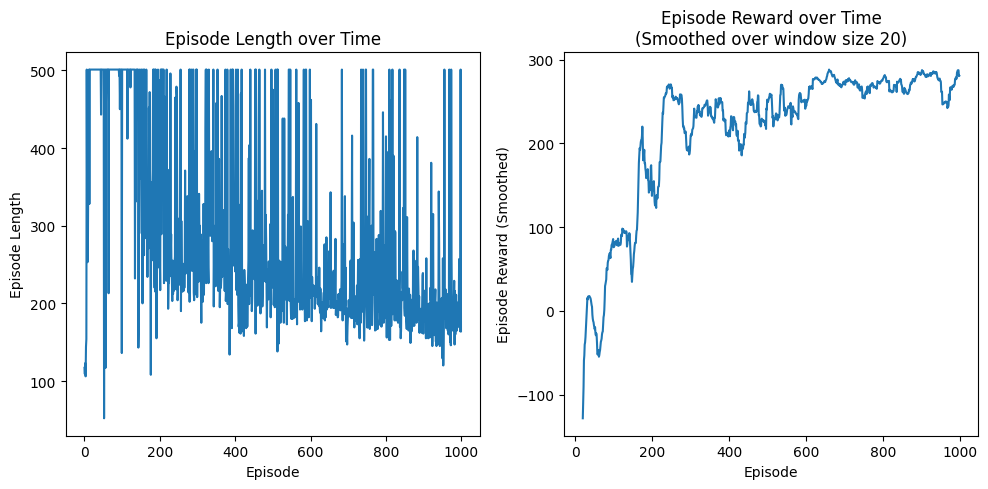

In [52]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

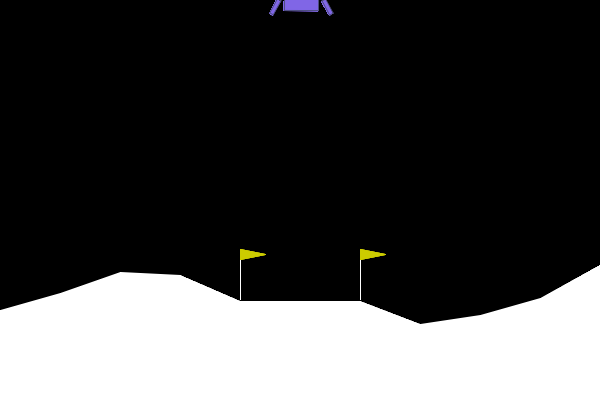

In [53]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32))[0].cpu().numpy()

        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")

We did not train very far because it can be very time-consuming.

---
<span style="color:orange">**EXERCISE**</span>: **RL Project Preperation**

1. What aspects of the problem should be first considered when trying to use RL for a particular task? (1 point)
2. Which quantities can be monitored during training in order to observe progress and help with debugging? (1 point)
3. What are some real world applications of RL? (1 point)

**Your answers:**
1. ..
2. ..
3. ..